**Building a Simple Regression Model**

In [17]:
import pandas as pd #data manipulation
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from lightgbm import LGBMRegressor, plot_importance #LightGBM models
from sklearn.model_selection import train_test_split #ML trainining
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
from yellowbrick.regressor import prediction_error, ResidualsPlot

Set plot fonts, etc. 

In [18]:
sns.set_context('talk')

Enable Pandas progress_apply

In [19]:
tqdm.pandas()

Read the data

In [20]:
df = pd.read_csv("solubility_data_ok.csv")

Set up property calculations

In [21]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

Define a function to calculate properties from SMILES

In [22]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        props = np.array(property_getter.ComputeProperties(mol))
    return props

Add the properties to the dataframe

In [23]:
df['props'] = df.SMILES.progress_apply(smi2props)

  0%|          | 0/1818 [00:00<?, ?it/s]

RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [19:40:26] WARNING: not removing hydrogen atom without neighbors


Put the descriptors into individual columns

In [24]:
df[property_names] = df['props'].to_list()

Split the data into training and test sets

In [25]:
train, test = train_test_split(df)

Define x and y variables for model building

In [26]:
train_X = train[property_names]
train_y = train.Solubility
test_X = test[property_names]
test_y = test.Solubility

Create a LightGBM Regressor

In [27]:
lgbm = LGBMRegressor()

Fit the model

In [28]:
lgbm.fit(train_X, train_y)

LGBMRegressor()

Make the prediction

In [29]:
pred = lgbm.predict(test_X)

Plot predicted vs experimental solubility

[Text(0, 0.5, 'Predicted LogS')]

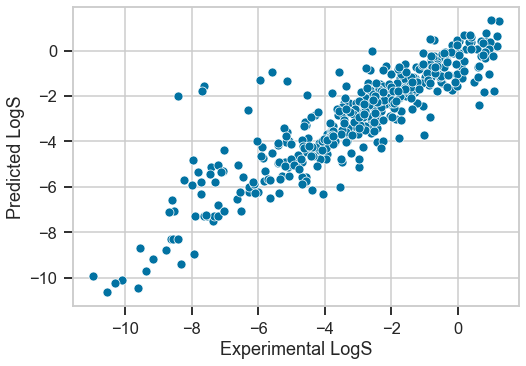

In [30]:
ax = sns.scatterplot(x=test_y,y=pred)
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Make the same plot with Seaborn's **regplot**

[Text(0, 0.5, 'Predicted LogS')]

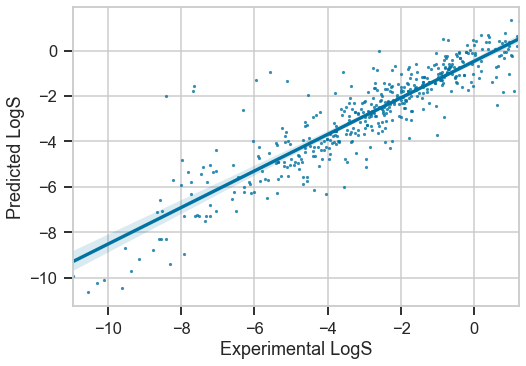

In [31]:
ax = sns.regplot(x=test_y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Calculate the coeffcient of determination (R<sup>2</sup>)

In [32]:
r2_score(test_y,pred)

0.8037717157351705

Calculate the RMS error

In [33]:
mean_squared_error(test_y,pred,squared=False)

1.0908366803546699

LightGBM provides an easy means of identifying important variables

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

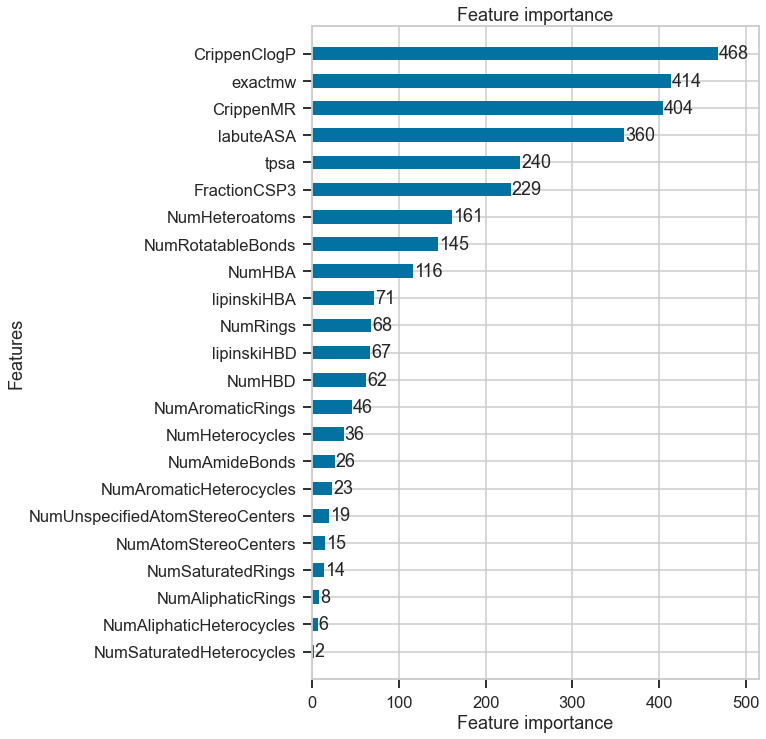

In [34]:
plot_importance(lgbm,figsize=(8,12),height=0.5)

The [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) Python library provides some useful diagnostic plots for ML models.

In [35]:
lgbm = LGBMRegressor()
train, test = train_test_split(df)
train_X = train[property_names]
train_y = train.Solubility
test_X = test[property_names]
test_y = test.Solubility

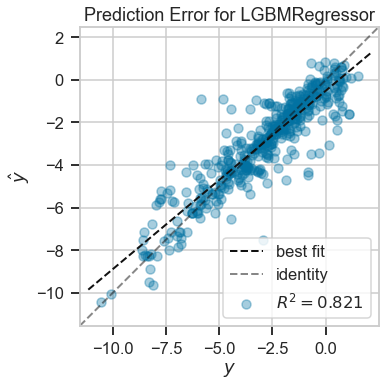

In [50]:
visualizer = prediction_error(lgbm, train_X, train_y, test_X, test_y,alpha=0.35)

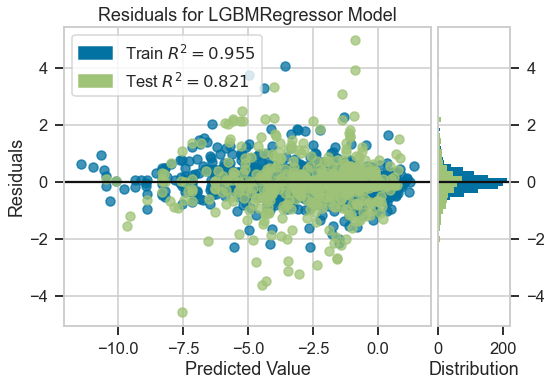

In [52]:
visualizer = ResidualsPlot(lgbm)
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
visualizer.show();

Run 10 cycles of cross validation on a model

In [38]:
r2_list = []
for i in tqdm(range(0,10)):
    # setup training and test sets
    train, test = train_test_split(df)
    train_X = train[property_names]
    train_y = train.Solubility
    test_X = test[property_names]
    test_y = test.Solubility
    # create the regressor
    lgbm = LGBMRegressor()
    # train the model
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict(test_X)
    r2 = r2_score(test_y,pred)
    print(r2)
    r2_list.append(r2)

  0%|          | 0/10 [00:00<?, ?it/s]

0.817896775121418
0.79041950447805
0.8307069244301961
0.8384601190506591
0.8593810686831241
0.8342938794332082
0.8462411136864991
0.8120615880348527
0.7878340554958136
0.8212861083736188


Plot R<sup>2</sup> across the 10 folds as a boxplot

[Text(0.5, 0, 'R$^2$')]

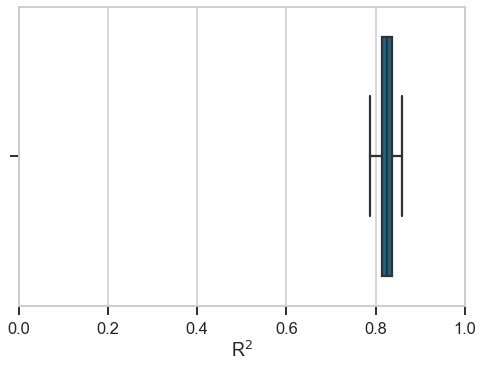

In [39]:
ax = sns.boxplot(x=r2_list)
ax.set(xlim=(0,1))
ax.set(xlabel="R$^2$")